In [1]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from betavae import BetaVAE, compile_vae, extract_latent_dimensions, weights
from optimize_utils import get_optimizer

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [2]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [5]:
# Load the best hyperparameters
study_name = "BetaVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']
hidden_dim = best_trial.params['hidden_dim']
num_layers = best_trial.params['num_layers']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [6]:
#Initialize the model and optimizer
model = BetaVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta, hidden_dim=hidden_dim, num_layers=num_layers)
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Train Loss: 117.32530025652986, Val Loss: 98.25081125895183, Test Loss: 97.62948269314236
Epoch 2, Train Loss: 106.17794280550373, Val Loss: 97.69362470838759, Test Loss: 98.11677636040582
Epoch 3, Train Loss: 97.17052056611473, Val Loss: 95.38801998562283, Test Loss: 93.54945966932509
Epoch 4, Train Loss: 90.13393627565299, Val Loss: 88.74486033121745, Test Loss: 88.07003529866536
Epoch 5, Train Loss: 84.05117843400187, Val Loss: 82.21987575954861, Test Loss: 81.49564446343317
Epoch 6, Train Loss: 79.01574306203358, Val Loss: 79.2427495320638, Test Loss: 77.66219838460286
Epoch 7, Train Loss: 74.89723501632463, Val Loss: 72.50094095865886, Test Loss: 71.67426045735677
Epoch 8, Train Loss: 71.37360548332556, Val Loss: 68.4854719373915, Test Loss: 69.58437008327908
Epoch 9, Train Loss: 68.36580045329991, Val Loss: 66.26653840806749, Test Loss: 66.65104675292969
Epoch 10, Train Loss: 65.98382386164879, Val Loss: 65.6389422946506, Test Loss: 64.64764319525824
Epoch 11, Train Loss

In [7]:
# Save the model
model_path = pathlib.Path("results/best_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [8]:
# Save training history
history = {
    'loss' : train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

history_path = pathlib.Path("results/training_history_layers.json")
with open(history_path, 'w') as f:
    json.dump(history, f)

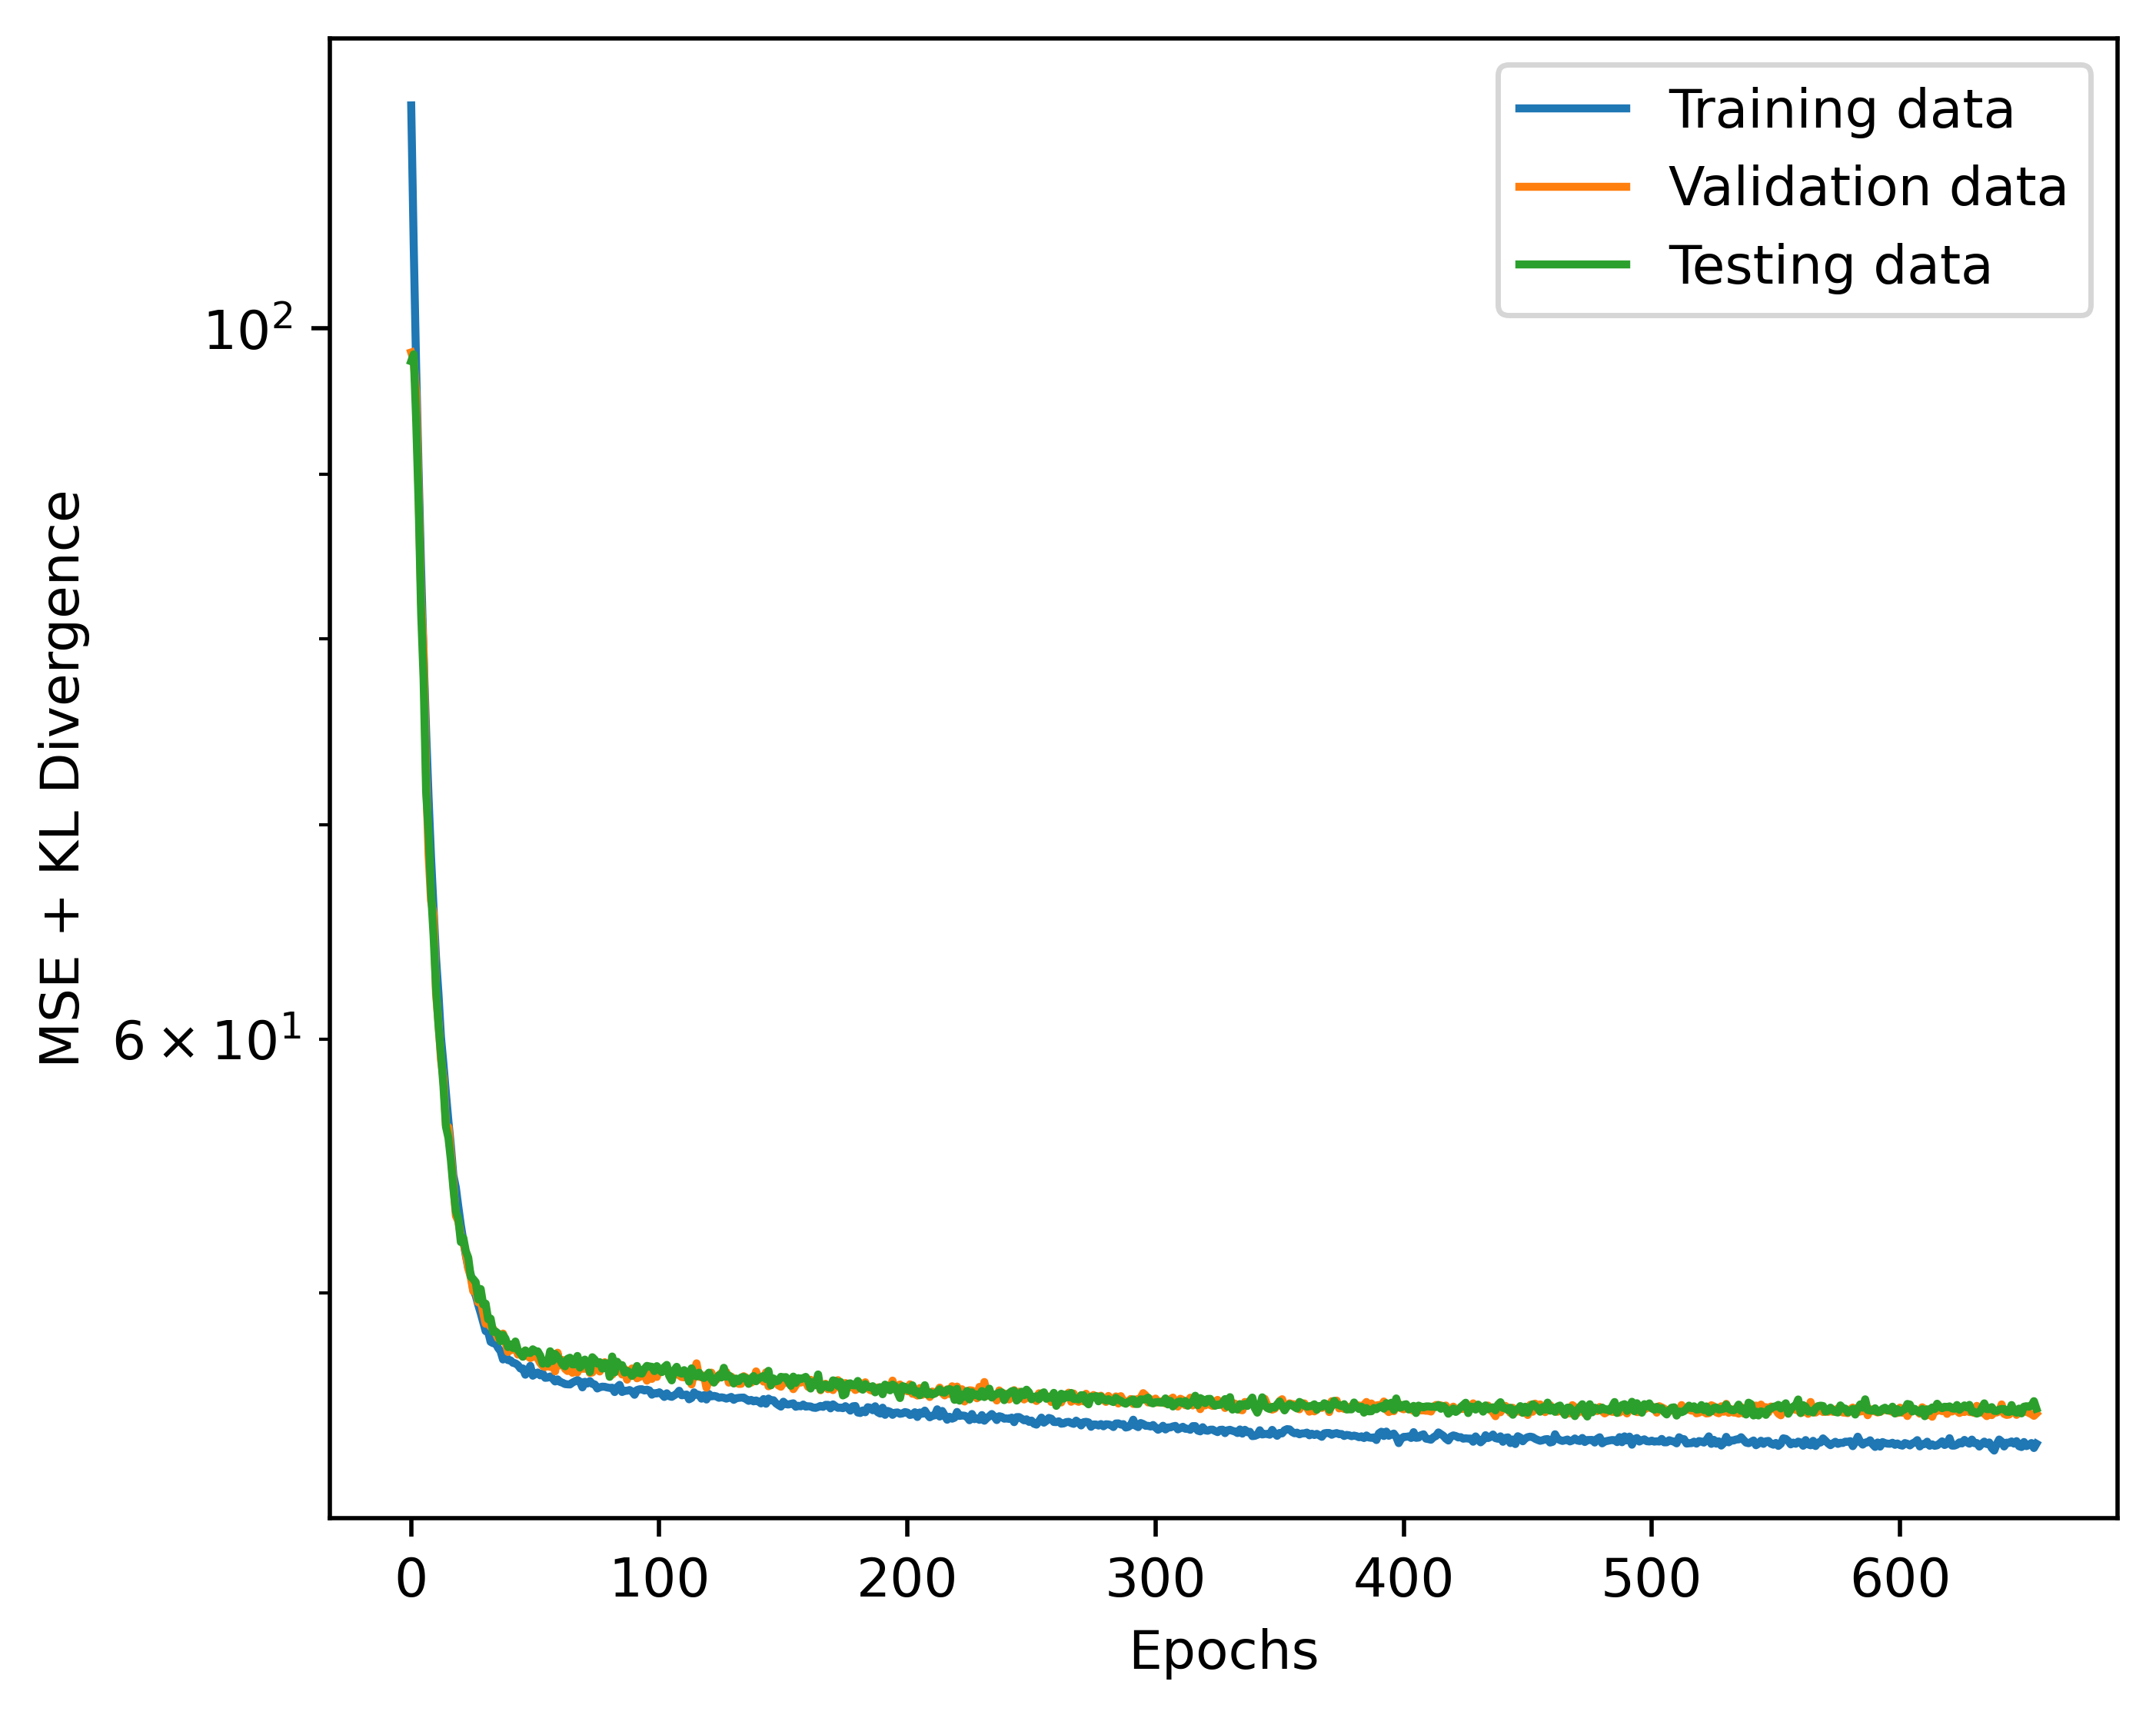

In [10]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(train_loss_history, label="Training data")
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

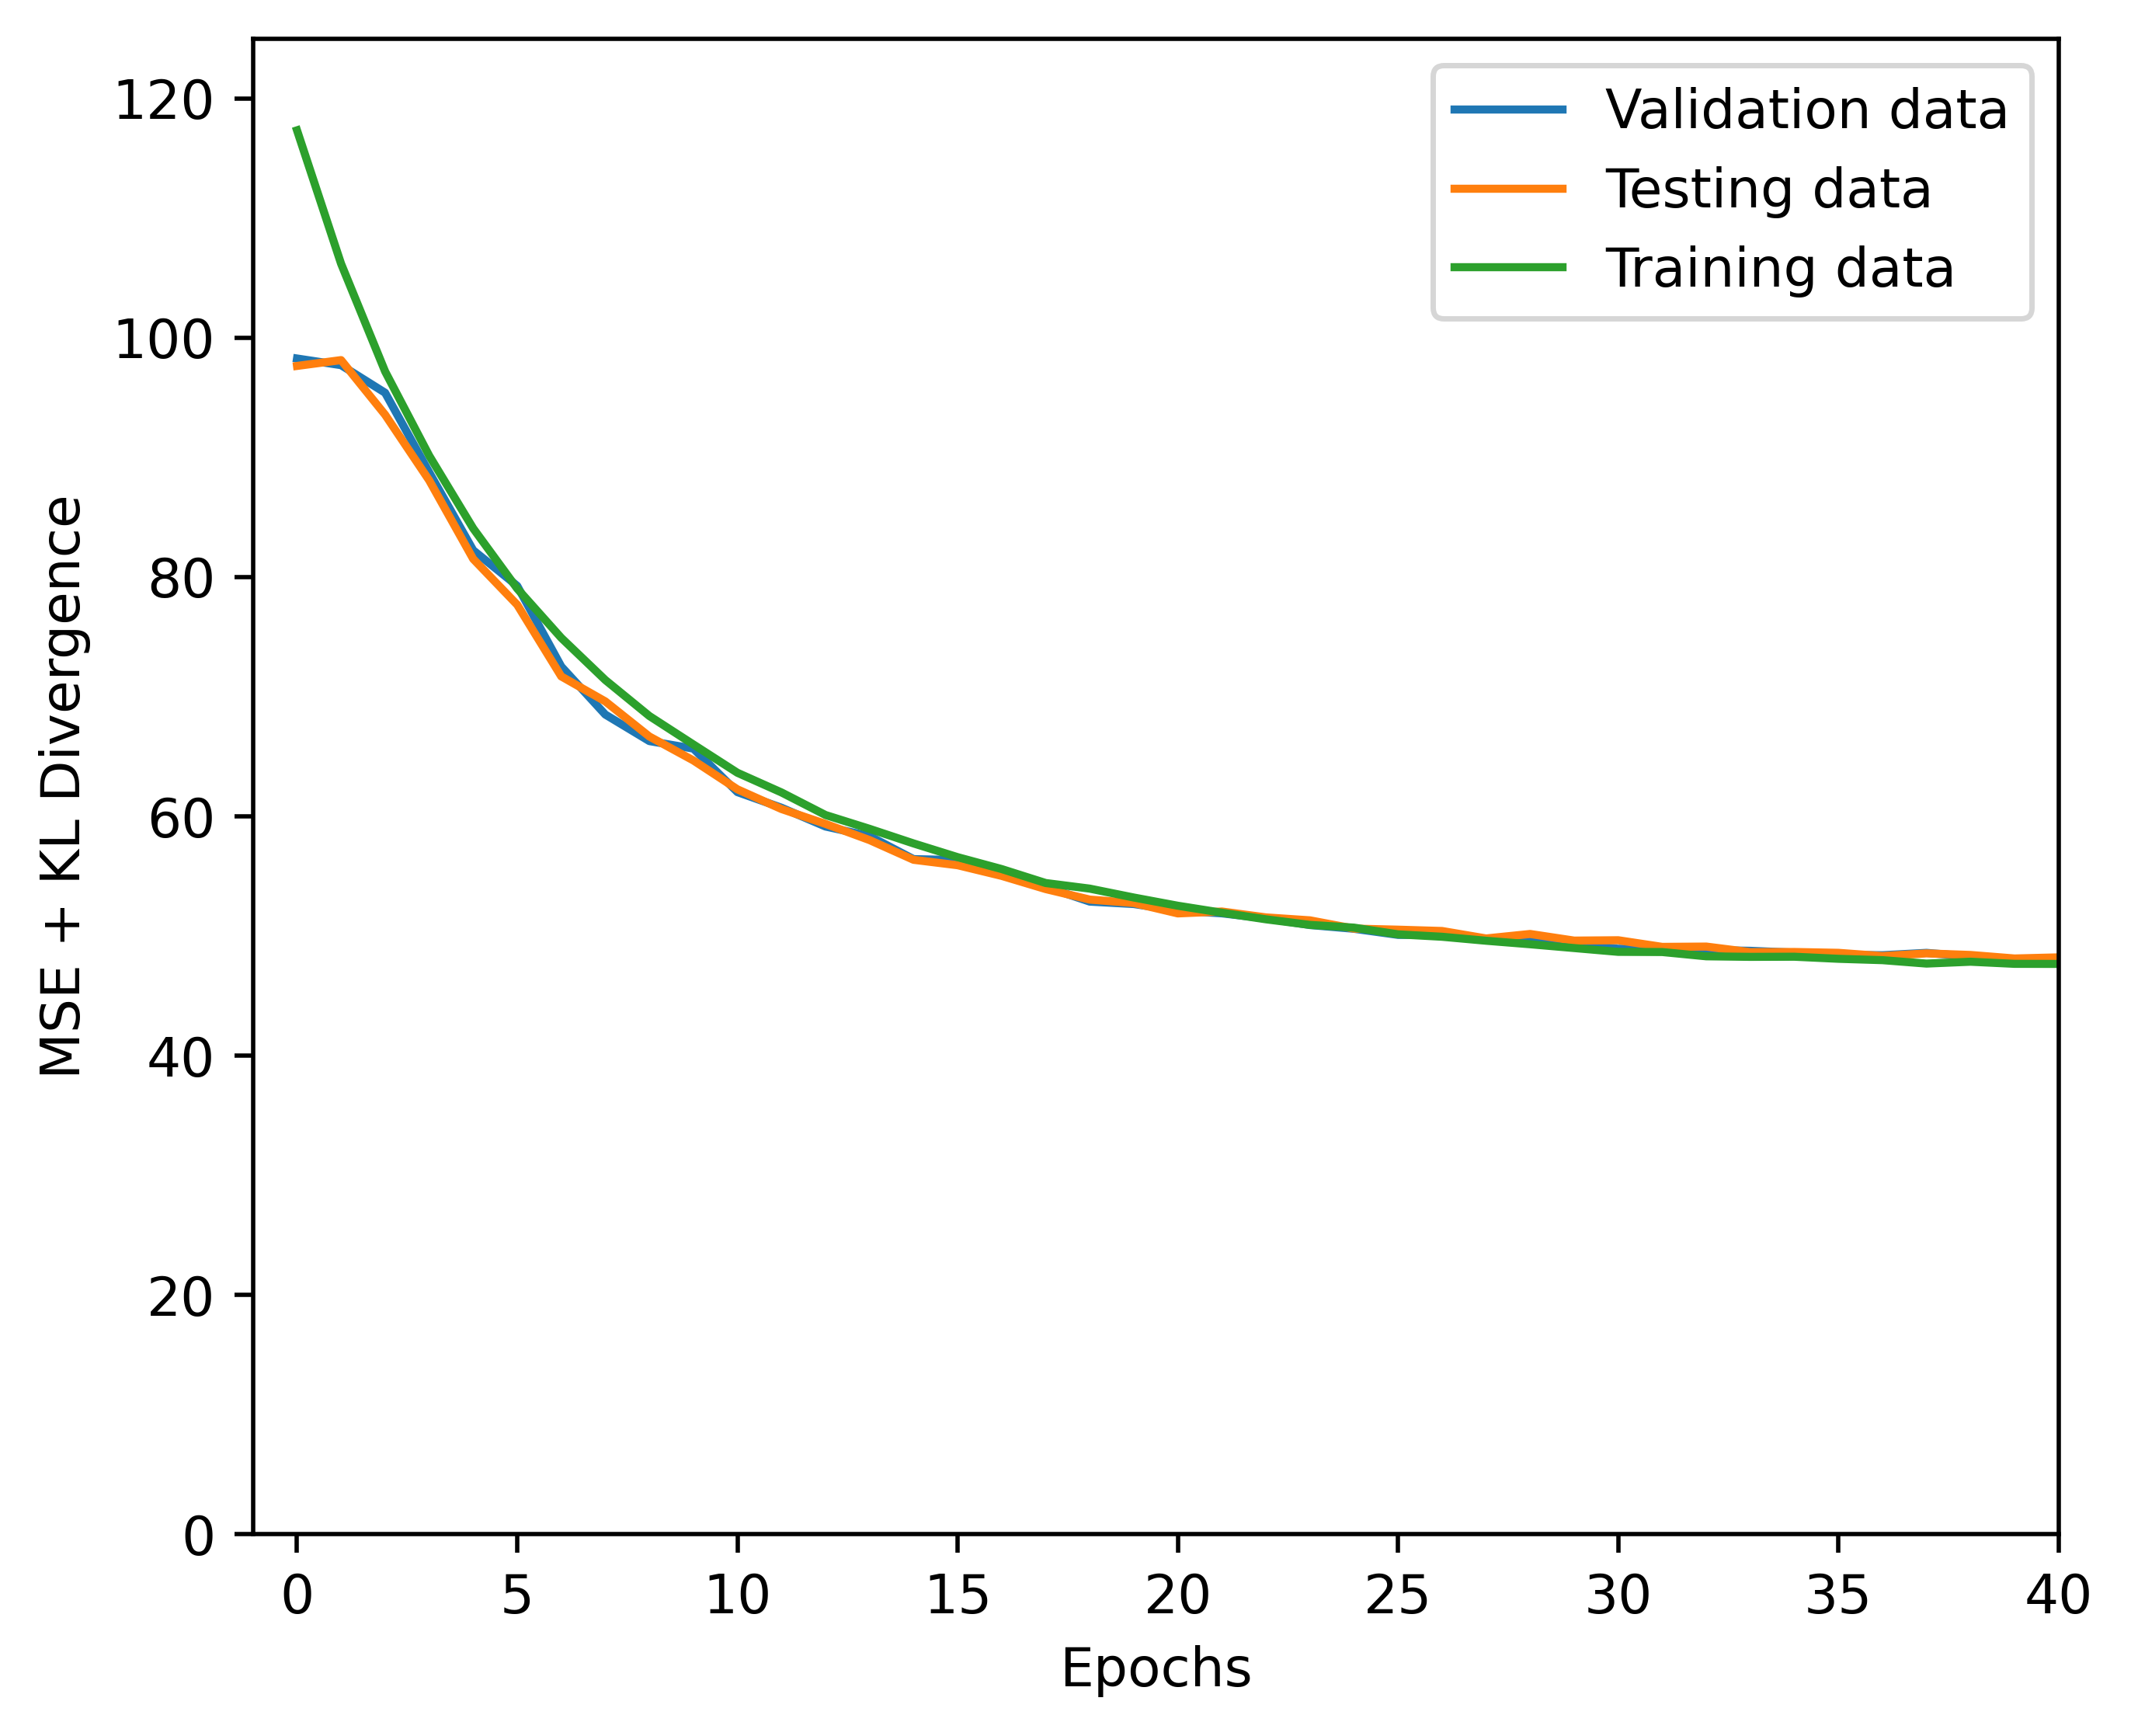

In [22]:
save_path = pathlib.Path("../1.data-exploration/figures/training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,40)
plt.ylim(0,125)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [15]:
# Extract the latent space dimensions
metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.parquet")
metadata = pd.read_parquet(metadata_df_dir)

train_and_test_subbed_dir = pathlib.Path("../0.data-download/data/train_and_test_subbed.parquet")
train_and_test_subbed = pd.read_parquet(train_and_test_subbed_dir)


# Convert DataFrame to NumPy and then Tensor
train_test_array = train_and_test_subbed.to_numpy()
train_test_tensor = torch.tensor(train_test_array, dtype=torch.float32)

#Create TensorDataset and DataLoader
tensor_dataset = TensorDataset(train_test_tensor)
train_and_test_subbed_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

latent_df = extract_latent_dimensions(model, train_and_test_subbed_loader, metadata)
print(latent_df.head())

#Save as parquet
latent_df_dir = pathlib.Path("./results/latent_df.parquet")

latent_df.to_parquet(latent_df_dir, index=False)

      ModelID         0         1         2         3         4         5  \
0  ACH-001578 -0.061492  0.007029 -6.094179 -0.094159 -0.109145  0.073394   
1  ACH-000569 -0.038440  0.020218 -4.984103 -0.091098 -0.081208  0.052447   
2  ACH-000963 -0.050444 -0.064262 -3.014910 -0.055242 -0.021424  0.066792   
3  ACH-000260 -0.019489  0.038373 -5.624078 -0.029354 -0.090506  0.031320   
4  ACH-000664 -0.155586 -0.015616 -7.972043 -0.177810 -0.166840  0.083458   

          6         7         8         9        10        11        12  \
0  0.126127 -0.351689 -0.233739  0.265656  0.145468  5.668900  0.068107   
1  0.117879 -0.252720 -0.210283  0.204859  0.122171  4.769199  0.055725   
2  0.049141 -0.170681 -0.162096  0.242632  0.077124  2.315709 -0.002664   
3  0.199174 -0.294608 -0.269363  0.095192  0.257269  6.715042  0.045149   
4  0.218212 -0.619663 -0.378863  0.457536  0.189318  5.429949  0.095612   

         13  
0 -0.091716  
1 -0.085750  
2 -0.093027  
3 -0.099033  
4 -0.179649  


In [18]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train"
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = weights(model, train_data)